In [ ]:
!wget https://www.dropbox.com/s/w3zlhing4dkgeyb/train.zip?dl=0

#unzip the data
!unzip train.zip?dl=0

--2023-10-18 13:46:31--  https://www.dropbox.com/s/w3zlhing4dkgeyb/train.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/w3zlhing4dkgeyb/train.zip [following]
--2023-10-18 13:46:32--  https://www.dropbox.com/s/raw/w3zlhing4dkgeyb/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8e71f6d84fa84bcddf61f7962b.dl.dropboxusercontent.com/cd/0/inline/CF1f0xm4LpMcdSpJYAGhQBUEX8jPER5F-8lBm4LSYUZimNU3OEaxTmjOy8SMZXKN62L9AMuPeotq0xvHV0JzYCaOOcu3t8vmV4IXy2igEdA-OUNGC71vnNTCwUSJIKqJzVh1TQMyrj6OmEiqV3_N6fy9/file# [following]
--2023-10-18 13:46:32--  https://uc8e71f6d84fa84bcddf61f7962b.dl.dropboxusercontent.com/cd/0/inline/CF1f0xm4LpMcdSpJYAGhQBUEX8jPER5F-8lBm4LSYUZimNU3OEaxTmjOy8SMZXKN62L9AMuPeotq0xvHV0JzYCaOOcu3t8vmV4IXy2ig

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.models import Model
from keras.layers import Flatten, Dense

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

Building Model

In [ ]:
base_model = MobileNet(input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(units=7, activation= 'softmax')(x)

#creating model
model = Model(base_model.input, x)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128 

In [ ]:
model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

Preparing data using data generator

In [ ]:
train_datagen = ImageDataGenerator(
    zoom_range = 0.2,
    shear_range= 0.2,
    horizontal_flip= True,
    rescale = 1./255
)

train_data = train_datagen.flow_from_directory(directory = "/content/train", target_size=(224,224), batch_size=32,)

train_data.class_indices

Found 350 images belonging to 7 classes.


{'Angry': 0,
 'Disguist': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1/255)

val_data = val_datagen.flow_from_directory(directory = "/content/train", target_size=(224,224), batch_size=32,)

Found 350 images belonging to 7 classes.


Visualizing data

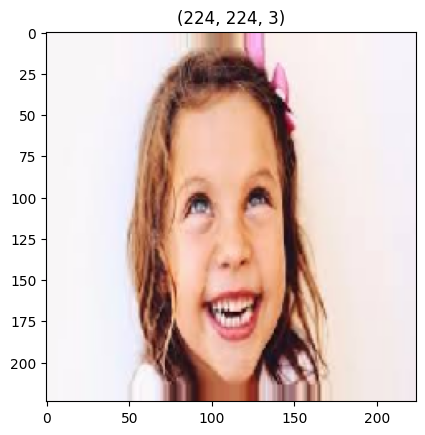

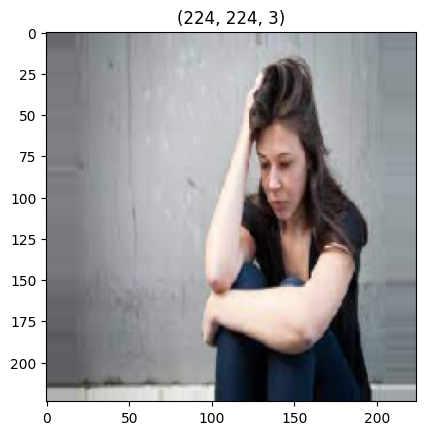

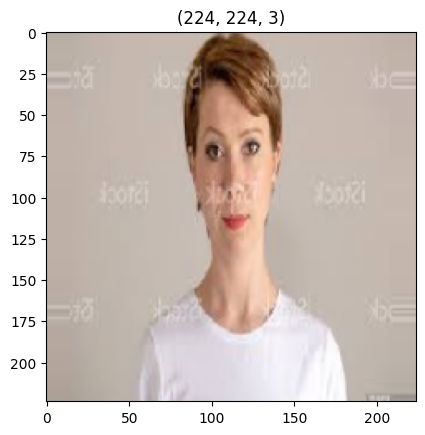

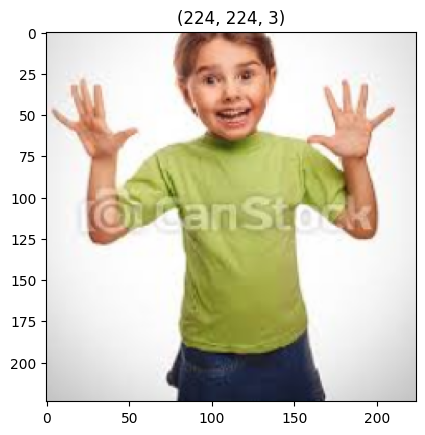

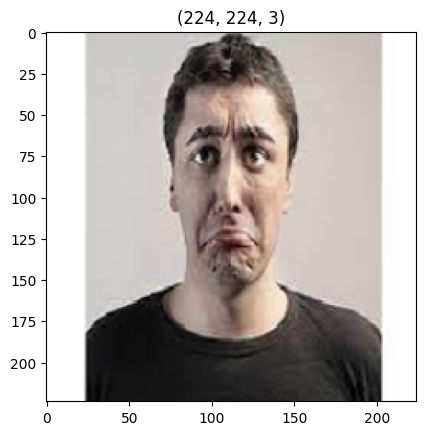

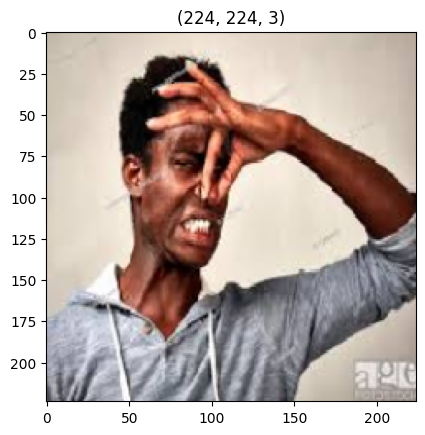

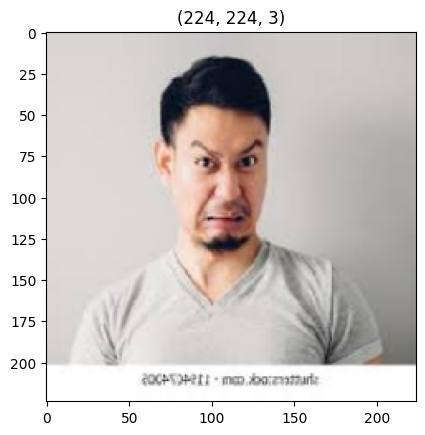

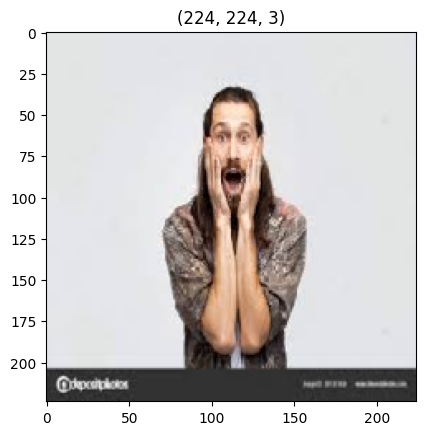

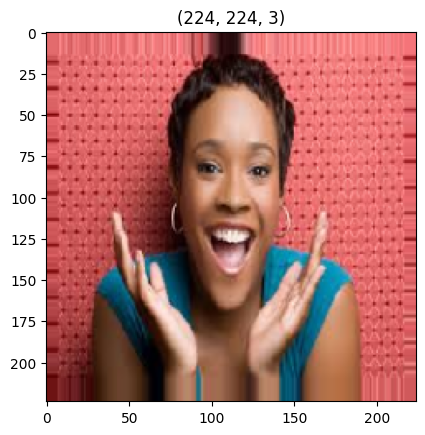

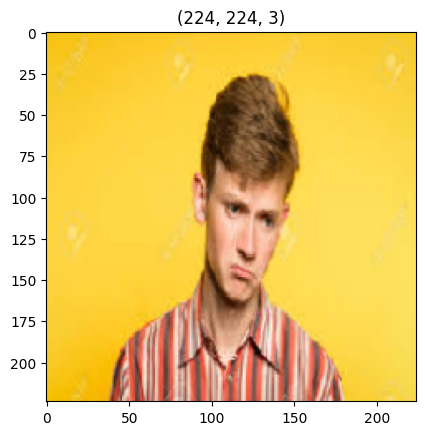

In [ ]:
t_img, label = train_data.next()

def plotImages(img_arr, label):
  """
  input :- images array
  output :- plots the image
  """
  count = 0
  for im, l in zip(img_arr, label):
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis= False
    plt.show()

    count += 1
    if count == 10:
      break

plotImages(t_img, label)

Early stopping and model checkpoint

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=5, verbose=1, mode='auto')

#model checkpoint
mc = ModelCheckpoint(filepath= "best_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

#call back
call_back = [es, mc]

In [ ]:
hist = model.fit_generator(train_data,
                           steps_per_epoch=10,
                           epochs=30,
                           validation_data = val_data,
                           validation_steps=8,
                           callbacks=[es, mc])

<ipython-input-15-f977201350ee>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_data,


Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 9.7102 - accuracy: 0.2264 
Epoch 1: val_accuracy improved from -inf to 0.48438, saving model to best_model.h5
10/10 [==============================] - 27s 3s/step - loss: 9.7102 - accuracy: 0.2264 - val_loss: 4.0865 - val_accuracy: 0.4844


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 3.5910 - accuracy: 0.5189
Epoch 2: val_accuracy improved from 0.48438 to 0.77734, saving model to best_model.h5
10/10 [==============================] - 26s 3s/step - loss: 3.5910 - accuracy: 0.5189 - val_loss: 1.3433 - val_accuracy: 0.7773
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 1.8831 - accuracy: 0.7138
Epoch 3: val_accuracy did not improve from 0.77734
10/10 [==============================] - 24s 3s/step - loss: 1.8831 - accuracy: 0.7138 - val_loss: 1.3187 - val_accuracy: 0.7656
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.9606 - accuracy: 0.8113
Epoch 4: val_accuracy improved from 0.77734 to 0.89453, saving model to best_model.h5
10/10 [==============================] - 24s 3s/step - loss: 0.9606 - accuracy: 0.8113 - val_loss: 0.7122 - val_accuracy: 0.8945
Epoch 5/30
10/10 [==============================] - ETA: 0s - loss: 0.5940 - accuracy: 0.8813
Epoch 5: val_a

In [ ]:
from keras.models import load_model
model = load_model("/content/best_model.h5")

In [ ]:
h = hist.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

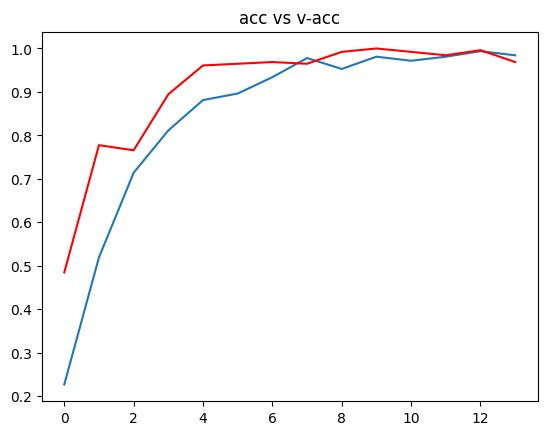

In [ ]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c='red')
plt.title("acc vs v-acc")
plt.show()

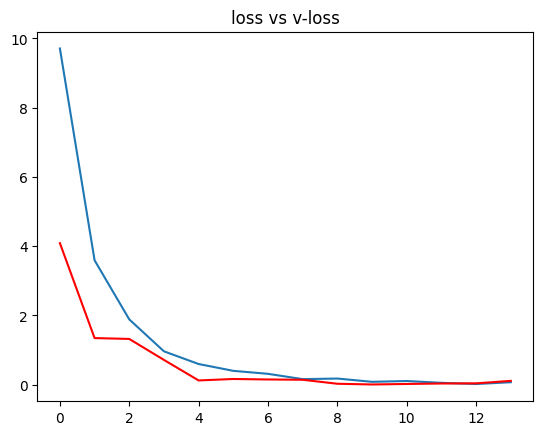

In [ ]:
plt.plot(h['loss'])
plt.plot(h['val_loss'], c='red')
plt.title("loss vs v-loss")
plt.show()

In [ ]:
#mapping o/p values
op = dict(zip(train_data.class_indices.values(), train_data.class_indices.keys()))

1/1 [==============================] - 0s 84ms/step
 the image is of Surprise


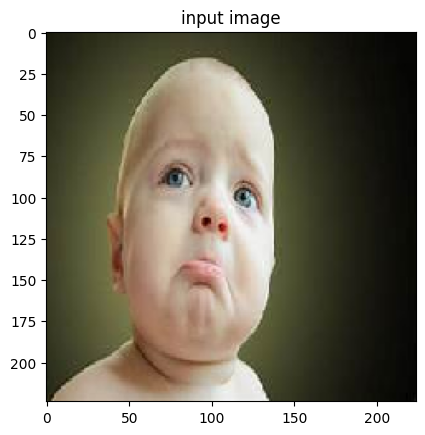

In [ ]:
path = "/content/sed.jpeg"
img = load_img(path, target_size= (224,224))

i = img_to_array(img)/255
input_arr = np.array([i])
input_arr.shape

pred = np.argmax(model.predict(input_arr))

print(f" the image is of {op[pred]}")

plt.imshow(input_arr[0])
plt.title("input image")
plt.show()